In [ ]:
import torch
import numpy as np
import networkx as nx
from olga import OLGA
from torch_geometric.nn import GAE
from oneclass import one_class_loss, one_class_masking, One_Class_GNN_prediction, EarlyStopping
from torch_geometric.utils.convert import from_networkx
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)
import matplotlib.pyplot as plt
from IPython.display import HTML
from IPython.display import display
from matplotlib import animation

/home/golo/miniconda3/envs/aocgnn_pytorch/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def animate(i):
    embed = embeddings[i].detach().cpu().numpy()
    center = centers[i].detach().cpu().numpy()
    r = radiuss[i].detach().cpu().numpy()
    ax.clear()
    ax.scatter(embed[:, 0], embed[:, 1], s=100, c=G.label, cmap="hsv", vmin=-2, vmax=3)
    ax.scatter(center[0], center[1], s=35, c='red', cmap="hsv", vmin=-2, vmax=3)
    circle = plt.Circle((center[0], center[1]), r, color='red', fill=False)
    plt.gca().add_artist(circle)
    plt.title(f'Ep {i} | loss: {losses[i]:.4f} | Rec: 'f'{losses_rec[i]:.4f} |'
              ' Ocl: 'f'{losses_ocl[i]:.4f} | F1: {accuracies[i]*100:.2f}%', fontsize=13, pad=40)

    plt.xlim([-1, 1])
    plt.ylim([-1, 1])

In [ ]:
learn_radius = False
learn_center = False

file = 'datasets/relevant_reviews_k=1_fold=0.gpickle'

g = nx.read_gpickle(file)

mask, t_mask, mask_unsup, t_mask_unsup = one_class_masking(g, True)

G = from_networkx(g)

hidden1 = 48

hidden2 = 2

c = [0] * hidden2
r = [0.35]
c = torch.Tensor(c)
r = torch.Tensor(r)

model_ocl = OLGA(len(G.features[0]), [hidden1, hidden2])
model = GAE(model_ocl)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

patience = 300

stopper = EarlyStopping(patience)

centers = []
embeddings = []
losses_ocl = []
losses_rec = []
accuracies = []
radiuss = []
losses = []

best_embeddings, best_radius, best_center = [], 0, []
# Training loop

g_unsup = g.subgraph(t_mask_unsup)
G_unsup = from_networkx(g_unsup)

loss_ocl = 0
recon_loss_unsup = 0

radius = r
center = c

for epoch in range(10001):
    # Clear gradients
    optimizer.zero_grad()

    # Forward pass

    learned_representations = model.encode(G.features.float(), G.edge_index)

    if epoch < patience / 2:
        loss = model.recon_loss(learned_representations, G.edge_index)
    else:
        loss_ocl = one_class_loss(center, radius, learned_representations, mask)

        recon_loss_unsup = model.recon_loss(learned_representations[mask_unsup], G_unsup.edge_index)

        loss = loss_ocl + recon_loss_unsup

    f1 = One_Class_GNN_prediction(center, radius, learned_representations, g, 'test', True)['macro avg']['f1-score']

    # Compute gradients
    loss.backward()

    # Tune parameters
    optimizer.step()

    print(f'Epoch {epoch:>3} | Loss: {loss:.5f} | F1: {f1*100:.2f}% | Loss_R: {recon_loss_unsup:.5f} |  Loss_O: '
          f''f'{loss_ocl:.5f} | R: {torch.abs(torch.mean(radius)):.2f}')

    stop, best_embeddings, best_radius, best_center, best_epoch = stopper.step(f1, loss, epoch, radius, center,
                                                                               learned_representations)

    embeddings.append(learned_representations)
    losses_ocl.append(loss_ocl)
    losses_rec.append(recon_loss_unsup)
    losses.append(loss)
    accuracies.append(f1)
    centers.append(center)
    radiuss.append(radius)

    if stop:
        break

One_Class_GNN_prediction(best_center, best_radius, best_embeddings, g, 'test', False)

Epoch   0 | Loss: 1.38289 | F1: 10.43% | Loss_R: 0.00000 |  Loss_O: 0.00000 | R: 0.35
Epoch   1 | Loss: 1.38156 | F1: 10.48% | Loss_R: 0.00000 |  Loss_O: 0.00000 | R: 0.35
Epoch   2 | Loss: 1.37973 | F1: 10.60% | Loss_R: 0.00000 |  Loss_O: 0.00000 | R: 0.35
Epoch   3 | Loss: 1.37747 | F1: 11.60% | Loss_R: 0.00000 |  Loss_O: 0.00000 | R: 0.35
Epoch   4 | Loss: 1.37486 | F1: 14.19% | Loss_R: 0.00000 |  Loss_O: 0.00000 | R: 0.35
Epoch   5 | Loss: 1.37205 | F1: 17.94% | Loss_R: 0.00000 |  Loss_O: 0.00000 | R: 0.35
Epoch   6 | Loss: 1.36908 | F1: 22.55% | Loss_R: 0.00000 |  Loss_O: 0.00000 | R: 0.35
Epoch   7 | Loss: 1.36542 | F1: 28.33% | Loss_R: 0.00000 |  Loss_O: 0.00000 | R: 0.35
Epoch   8 | Loss: 1.36237 | F1: 33.59% | Loss_R: 0.00000 |  Loss_O: 0.00000 | R: 0.35
Epoch   9 | Loss: 1.35890 | F1: 38.22% | Loss_R: 0.00000 |  Loss_O: 0.00000 | R: 0.35
Epoch  10 | Loss: 1.35513 | F1: 42.17% | Loss_R: 0.00000 |  Loss_O: 0.00000 | R: 0.35
Epoch  11 | Loss: 1.35180 | F1: 44.85% | Loss_R: 0.000

Epoch  98 | Loss: 1.08146 | F1: 48.77% | Loss_R: 0.00000 |  Loss_O: 0.00000 | R: 0.35
Epoch  99 | Loss: 1.08386 | F1: 48.79% | Loss_R: 0.00000 |  Loss_O: 0.00000 | R: 0.35
Epoch 100 | Loss: 1.07723 | F1: 48.81% | Loss_R: 0.00000 |  Loss_O: 0.00000 | R: 0.35
Epoch 101 | Loss: 1.08171 | F1: 48.86% | Loss_R: 0.00000 |  Loss_O: 0.00000 | R: 0.35
Epoch 102 | Loss: 1.06955 | F1: 48.92% | Loss_R: 0.00000 |  Loss_O: 0.00000 | R: 0.35
Epoch 103 | Loss: 1.07539 | F1: 48.94% | Loss_R: 0.00000 |  Loss_O: 0.00000 | R: 0.35
Epoch 104 | Loss: 1.07534 | F1: 48.97% | Loss_R: 0.00000 |  Loss_O: 0.00000 | R: 0.35
Epoch 105 | Loss: 1.07116 | F1: 48.99% | Loss_R: 0.00000 |  Loss_O: 0.00000 | R: 0.35
Epoch 106 | Loss: 1.07186 | F1: 48.73% | Loss_R: 0.00000 |  Loss_O: 0.00000 | R: 0.35
Epoch 107 | Loss: 1.07032 | F1: 48.73% | Loss_R: 0.00000 |  Loss_O: 0.00000 | R: 0.35
Epoch 108 | Loss: 1.07233 | F1: 48.75% | Loss_R: 0.00000 |  Loss_O: 0.00000 | R: 0.35
Epoch 109 | Loss: 1.07524 | F1: 48.75% | Loss_R: 0.000

Epoch 194 | Loss: 2.23163 | F1: 66.98% | Loss_R: 1.20788 |  Loss_O: 1.02374 | R: 0.35
Epoch 195 | Loss: 2.22140 | F1: 67.04% | Loss_R: 1.20681 |  Loss_O: 1.01458 | R: 0.35
Epoch 196 | Loss: 2.21854 | F1: 67.16% | Loss_R: 1.21209 |  Loss_O: 1.00645 | R: 0.35
Epoch 197 | Loss: 2.21679 | F1: 67.14% | Loss_R: 1.21750 |  Loss_O: 0.99930 | R: 0.35
Epoch 198 | Loss: 2.20021 | F1: 66.97% | Loss_R: 1.20714 |  Loss_O: 0.99307 | R: 0.35
Epoch 199 | Loss: 2.20131 | F1: 67.20% | Loss_R: 1.21361 |  Loss_O: 0.98769 | R: 0.35
Epoch 200 | Loss: 2.19802 | F1: 67.20% | Loss_R: 1.21497 |  Loss_O: 0.98304 | R: 0.35
Epoch 201 | Loss: 2.18860 | F1: 66.99% | Loss_R: 1.20955 |  Loss_O: 0.97905 | R: 0.35
Epoch 202 | Loss: 2.18633 | F1: 66.96% | Loss_R: 1.21069 |  Loss_O: 0.97564 | R: 0.35
Epoch 203 | Loss: 2.18218 | F1: 67.13% | Loss_R: 1.20944 |  Loss_O: 0.97274 | R: 0.35
Epoch 204 | Loss: 2.18006 | F1: 66.93% | Loss_R: 1.20977 |  Loss_O: 0.97029 | R: 0.35
Epoch 205 | Loss: 2.17362 | F1: 66.92% | Loss_R: 1.205

Epoch 291 | Loss: 2.10430 | F1: 67.65% | Loss_R: 1.16217 |  Loss_O: 0.94212 | R: 0.35
Epoch 292 | Loss: 2.10191 | F1: 67.83% | Loss_R: 1.15975 |  Loss_O: 0.94216 | R: 0.35
Epoch 293 | Loss: 2.09741 | F1: 67.87% | Loss_R: 1.15524 |  Loss_O: 0.94217 | R: 0.35
Epoch 294 | Loss: 2.10471 | F1: 67.83% | Loss_R: 1.16251 |  Loss_O: 0.94220 | R: 0.35
Epoch 295 | Loss: 2.10243 | F1: 67.70% | Loss_R: 1.16025 |  Loss_O: 0.94218 | R: 0.35
Epoch 296 | Loss: 2.10297 | F1: 67.65% | Loss_R: 1.16081 |  Loss_O: 0.94216 | R: 0.35
Epoch 297 | Loss: 2.10372 | F1: 67.80% | Loss_R: 1.16159 |  Loss_O: 0.94213 | R: 0.35
Epoch 298 | Loss: 2.09891 | F1: 67.84% | Loss_R: 1.15686 |  Loss_O: 0.94205 | R: 0.35
Epoch 299 | Loss: 2.09823 | F1: 67.84% | Loss_R: 1.15627 |  Loss_O: 0.94196 | R: 0.35
Epoch 300 | Loss: 2.10288 | F1: 67.74% | Loss_R: 1.16092 |  Loss_O: 0.94196 | R: 0.35
Epoch 301 | Loss: 2.10903 | F1: 67.74% | Loss_R: 1.16708 |  Loss_O: 0.94196 | R: 0.35
Epoch 302 | Loss: 2.09831 | F1: 67.74% | Loss_R: 1.156

Epoch 387 | Loss: 2.09315 | F1: 68.37% | Loss_R: 1.15243 |  Loss_O: 0.94073 | R: 0.35
Epoch 388 | Loss: 2.07991 | F1: 68.28% | Loss_R: 1.13927 |  Loss_O: 0.94064 | R: 0.35
Epoch 389 | Loss: 2.08425 | F1: 68.23% | Loss_R: 1.14368 |  Loss_O: 0.94057 | R: 0.35
Epoch 390 | Loss: 2.08485 | F1: 68.23% | Loss_R: 1.14434 |  Loss_O: 0.94051 | R: 0.35
Epoch 391 | Loss: 2.08033 | F1: 68.23% | Loss_R: 1.13985 |  Loss_O: 0.94048 | R: 0.35
Epoch 392 | Loss: 2.07798 | F1: 68.23% | Loss_R: 1.13752 |  Loss_O: 0.94046 | R: 0.35
Epoch 393 | Loss: 2.08597 | F1: 68.23% | Loss_R: 1.14550 |  Loss_O: 0.94047 | R: 0.35
Epoch 394 | Loss: 2.08536 | F1: 68.32% | Loss_R: 1.14484 |  Loss_O: 0.94053 | R: 0.35
Epoch 395 | Loss: 2.07496 | F1: 68.32% | Loss_R: 1.13439 |  Loss_O: 0.94057 | R: 0.35
Epoch 396 | Loss: 2.07653 | F1: 68.37% | Loss_R: 1.13586 |  Loss_O: 0.94068 | R: 0.35
Epoch 397 | Loss: 2.08344 | F1: 68.37% | Loss_R: 1.14266 |  Loss_O: 0.94078 | R: 0.35
Epoch 398 | Loss: 2.07978 | F1: 68.32% | Loss_R: 1.138

Epoch 484 | Loss: 2.07539 | F1: 69.49% | Loss_R: 1.13499 |  Loss_O: 0.94040 | R: 0.35
Epoch 485 | Loss: 2.07249 | F1: 69.53% | Loss_R: 1.13198 |  Loss_O: 0.94051 | R: 0.35
Epoch 486 | Loss: 2.07085 | F1: 69.49% | Loss_R: 1.13039 |  Loss_O: 0.94047 | R: 0.35
Epoch 487 | Loss: 2.07341 | F1: 69.44% | Loss_R: 1.13306 |  Loss_O: 0.94035 | R: 0.35
Epoch 488 | Loss: 2.07302 | F1: 69.44% | Loss_R: 1.13278 |  Loss_O: 0.94023 | R: 0.35
Epoch 489 | Loss: 2.06404 | F1: 69.44% | Loss_R: 1.12389 |  Loss_O: 0.94015 | R: 0.35
Epoch 490 | Loss: 2.07021 | F1: 69.49% | Loss_R: 1.13016 |  Loss_O: 0.94005 | R: 0.35
Epoch 491 | Loss: 2.06956 | F1: 69.54% | Loss_R: 1.12964 |  Loss_O: 0.93991 | R: 0.35
Epoch 492 | Loss: 2.06354 | F1: 69.41% | Loss_R: 1.12376 |  Loss_O: 0.93978 | R: 0.35
Epoch 493 | Loss: 2.06859 | F1: 69.55% | Loss_R: 1.12889 |  Loss_O: 0.93971 | R: 0.35
Epoch 494 | Loss: 2.06457 | F1: 69.55% | Loss_R: 1.12497 |  Loss_O: 0.93961 | R: 0.35
Epoch 495 | Loss: 2.06413 | F1: 69.50% | Loss_R: 1.124

Epoch 580 | Loss: 2.06297 | F1: 69.49% | Loss_R: 1.12364 |  Loss_O: 0.93933 | R: 0.35
Epoch 581 | Loss: 2.06316 | F1: 69.67% | Loss_R: 1.12365 |  Loss_O: 0.93951 | R: 0.35
Epoch 582 | Loss: 2.06613 | F1: 69.76% | Loss_R: 1.12645 |  Loss_O: 0.93968 | R: 0.35
Epoch 583 | Loss: 2.05175 | F1: 69.76% | Loss_R: 1.11202 |  Loss_O: 0.93973 | R: 0.35
Epoch 584 | Loss: 2.06406 | F1: 69.90% | Loss_R: 1.12431 |  Loss_O: 0.93975 | R: 0.35
Epoch 585 | Loss: 2.06522 | F1: 69.95% | Loss_R: 1.12547 |  Loss_O: 0.93975 | R: 0.35
Epoch 586 | Loss: 2.05472 | F1: 69.99% | Loss_R: 1.11499 |  Loss_O: 0.93973 | R: 0.35
Epoch 587 | Loss: 2.06796 | F1: 69.99% | Loss_R: 1.12825 |  Loss_O: 0.93972 | R: 0.35
Epoch 588 | Loss: 2.06080 | F1: 70.05% | Loss_R: 1.12117 |  Loss_O: 0.93963 | R: 0.35
Epoch 589 | Loss: 2.06160 | F1: 69.91% | Loss_R: 1.12211 |  Loss_O: 0.93949 | R: 0.35
Epoch 590 | Loss: 2.05912 | F1: 69.86% | Loss_R: 1.11973 |  Loss_O: 0.93939 | R: 0.35
Epoch 591 | Loss: 2.05572 | F1: 69.86% | Loss_R: 1.116

Epoch 676 | Loss: 2.06045 | F1: 70.61% | Loss_R: 1.12160 |  Loss_O: 0.93885 | R: 0.35
Epoch 677 | Loss: 2.06225 | F1: 70.60% | Loss_R: 1.12348 |  Loss_O: 0.93878 | R: 0.35
Epoch 678 | Loss: 2.05643 | F1: 70.60% | Loss_R: 1.11762 |  Loss_O: 0.93881 | R: 0.35
Epoch 679 | Loss: 2.05746 | F1: 70.66% | Loss_R: 1.11852 |  Loss_O: 0.93894 | R: 0.35
Epoch 680 | Loss: 2.05091 | F1: 70.51% | Loss_R: 1.11181 |  Loss_O: 0.93910 | R: 0.35
Epoch 681 | Loss: 2.05046 | F1: 70.56% | Loss_R: 1.11108 |  Loss_O: 0.93938 | R: 0.35
Epoch 682 | Loss: 2.06087 | F1: 70.60% | Loss_R: 1.12125 |  Loss_O: 0.93962 | R: 0.35
Epoch 683 | Loss: 2.05077 | F1: 70.60% | Loss_R: 1.11100 |  Loss_O: 0.93977 | R: 0.35
Epoch 684 | Loss: 2.05268 | F1: 70.65% | Loss_R: 1.11288 |  Loss_O: 0.93980 | R: 0.35
Epoch 685 | Loss: 2.05631 | F1: 70.79% | Loss_R: 1.11653 |  Loss_O: 0.93978 | R: 0.35
Epoch 686 | Loss: 2.05179 | F1: 70.79% | Loss_R: 1.11214 |  Loss_O: 0.93965 | R: 0.35
Epoch 687 | Loss: 2.05640 | F1: 70.85% | Loss_R: 1.116

Epoch 774 | Loss: 2.04961 | F1: 71.41% | Loss_R: 1.10996 |  Loss_O: 0.93965 | R: 0.35
Epoch 775 | Loss: 2.05585 | F1: 71.46% | Loss_R: 1.11622 |  Loss_O: 0.93963 | R: 0.35
Epoch 776 | Loss: 2.04767 | F1: 71.46% | Loss_R: 1.10802 |  Loss_O: 0.93965 | R: 0.35
Epoch 777 | Loss: 2.05204 | F1: 71.51% | Loss_R: 1.11236 |  Loss_O: 0.93968 | R: 0.35
Epoch 778 | Loss: 2.05213 | F1: 71.46% | Loss_R: 1.11252 |  Loss_O: 0.93961 | R: 0.35
Epoch 779 | Loss: 2.05364 | F1: 71.51% | Loss_R: 1.11406 |  Loss_O: 0.93958 | R: 0.35
Epoch 780 | Loss: 2.04505 | F1: 71.41% | Loss_R: 1.10547 |  Loss_O: 0.93958 | R: 0.35
Epoch 781 | Loss: 2.05086 | F1: 71.41% | Loss_R: 1.11124 |  Loss_O: 0.93962 | R: 0.35
Epoch 782 | Loss: 2.05476 | F1: 71.41% | Loss_R: 1.11511 |  Loss_O: 0.93966 | R: 0.35
Epoch 783 | Loss: 2.06027 | F1: 71.36% | Loss_R: 1.12066 |  Loss_O: 0.93961 | R: 0.35
Epoch 784 | Loss: 2.04870 | F1: 71.41% | Loss_R: 1.10921 |  Loss_O: 0.93949 | R: 0.35
Epoch 785 | Loss: 2.04787 | F1: 71.41% | Loss_R: 1.108

Epoch 872 | Loss: 2.04234 | F1: 71.34% | Loss_R: 1.10282 |  Loss_O: 0.93951 | R: 0.35
Epoch 873 | Loss: 2.04213 | F1: 71.34% | Loss_R: 1.10256 |  Loss_O: 0.93957 | R: 0.35
Epoch 874 | Loss: 2.04462 | F1: 71.34% | Loss_R: 1.10498 |  Loss_O: 0.93964 | R: 0.35
Epoch 875 | Loss: 2.04893 | F1: 71.34% | Loss_R: 1.10917 |  Loss_O: 0.93976 | R: 0.35
Epoch 876 | Loss: 2.04649 | F1: 71.34% | Loss_R: 1.10672 |  Loss_O: 0.93976 | R: 0.35
Epoch 877 | Loss: 2.04672 | F1: 71.34% | Loss_R: 1.10689 |  Loss_O: 0.93983 | R: 0.35
Epoch 878 | Loss: 2.04813 | F1: 71.33% | Loss_R: 1.10824 |  Loss_O: 0.93990 | R: 0.35
Epoch 879 | Loss: 2.03642 | F1: 71.49% | Loss_R: 1.09655 |  Loss_O: 0.93987 | R: 0.35
Epoch 880 | Loss: 2.03877 | F1: 71.49% | Loss_R: 1.09889 |  Loss_O: 0.93988 | R: 0.35
Epoch 881 | Loss: 2.04581 | F1: 71.44% | Loss_R: 1.10585 |  Loss_O: 0.93996 | R: 0.35
Epoch 882 | Loss: 2.05079 | F1: 71.53% | Loss_R: 1.11054 |  Loss_O: 0.94025 | R: 0.35
Epoch 883 | Loss: 2.04382 | F1: 71.58% | Loss_R: 1.103

Epoch 968 | Loss: 2.04501 | F1: 71.42% | Loss_R: 1.10515 |  Loss_O: 0.93987 | R: 0.35
Epoch 969 | Loss: 2.03719 | F1: 71.47% | Loss_R: 1.09728 |  Loss_O: 0.93991 | R: 0.35
Epoch 970 | Loss: 2.04468 | F1: 71.62% | Loss_R: 1.10457 |  Loss_O: 0.94011 | R: 0.35
Epoch 971 | Loss: 2.04593 | F1: 71.67% | Loss_R: 1.10559 |  Loss_O: 0.94033 | R: 0.35
Epoch 972 | Loss: 2.04535 | F1: 71.67% | Loss_R: 1.10493 |  Loss_O: 0.94042 | R: 0.35
Epoch 973 | Loss: 2.04366 | F1: 71.72% | Loss_R: 1.10319 |  Loss_O: 0.94047 | R: 0.35
Epoch 974 | Loss: 2.04275 | F1: 71.67% | Loss_R: 1.10235 |  Loss_O: 0.94041 | R: 0.35
Epoch 975 | Loss: 2.04327 | F1: 71.67% | Loss_R: 1.10306 |  Loss_O: 0.94021 | R: 0.35
Epoch 976 | Loss: 2.04200 | F1: 71.52% | Loss_R: 1.10192 |  Loss_O: 0.94008 | R: 0.35
Epoch 977 | Loss: 2.03666 | F1: 71.47% | Loss_R: 1.09667 |  Loss_O: 0.93998 | R: 0.35
Epoch 978 | Loss: 2.03848 | F1: 71.47% | Loss_R: 1.09848 |  Loss_O: 0.94000 | R: 0.35
Epoch 979 | Loss: 2.03813 | F1: 71.47% | Loss_R: 1.098

Epoch 1065 | Loss: 2.03053 | F1: 71.46% | Loss_R: 1.08947 |  Loss_O: 0.94105 | R: 0.35
Epoch 1066 | Loss: 2.04609 | F1: 71.50% | Loss_R: 1.10492 |  Loss_O: 0.94118 | R: 0.35
Epoch 1067 | Loss: 2.04063 | F1: 71.50% | Loss_R: 1.09943 |  Loss_O: 0.94120 | R: 0.35
Epoch 1068 | Loss: 2.04344 | F1: 71.50% | Loss_R: 1.10229 |  Loss_O: 0.94115 | R: 0.35
Epoch 1069 | Loss: 2.04636 | F1: 71.50% | Loss_R: 1.10540 |  Loss_O: 0.94096 | R: 0.35
Epoch 1070 | Loss: 2.04384 | F1: 71.36% | Loss_R: 1.10321 |  Loss_O: 0.94064 | R: 0.35
Epoch 1071 | Loss: 2.03701 | F1: 71.36% | Loss_R: 1.09654 |  Loss_O: 0.94047 | R: 0.35
Epoch 1072 | Loss: 2.03915 | F1: 71.36% | Loss_R: 1.09870 |  Loss_O: 0.94045 | R: 0.35
Epoch 1073 | Loss: 2.03037 | F1: 71.36% | Loss_R: 1.08987 |  Loss_O: 0.94050 | R: 0.35
Epoch 1074 | Loss: 2.03258 | F1: 71.40% | Loss_R: 1.09194 |  Loss_O: 0.94064 | R: 0.35
Epoch 1075 | Loss: 2.03973 | F1: 71.45% | Loss_R: 1.09886 |  Loss_O: 0.94086 | R: 0.35
Epoch 1076 | Loss: 2.03868 | F1: 71.45% | L

Epoch 1160 | Loss: 2.03199 | F1: 72.09% | Loss_R: 1.09038 |  Loss_O: 0.94161 | R: 0.35
Epoch 1161 | Loss: 2.03931 | F1: 72.09% | Loss_R: 1.09764 |  Loss_O: 0.94167 | R: 0.35
Epoch 1162 | Loss: 2.03760 | F1: 72.04% | Loss_R: 1.09594 |  Loss_O: 0.94166 | R: 0.35
Epoch 1163 | Loss: 2.03732 | F1: 71.99% | Loss_R: 1.09569 |  Loss_O: 0.94163 | R: 0.35
Epoch 1164 | Loss: 2.03307 | F1: 72.04% | Loss_R: 1.09138 |  Loss_O: 0.94169 | R: 0.35
Epoch 1165 | Loss: 2.03636 | F1: 72.04% | Loss_R: 1.09467 |  Loss_O: 0.94169 | R: 0.35
Epoch 1166 | Loss: 2.04361 | F1: 72.15% | Loss_R: 1.10187 |  Loss_O: 0.94174 | R: 0.35
Epoch 1167 | Loss: 2.03518 | F1: 72.15% | Loss_R: 1.09346 |  Loss_O: 0.94172 | R: 0.35
Epoch 1168 | Loss: 2.02828 | F1: 72.10% | Loss_R: 1.08665 |  Loss_O: 0.94162 | R: 0.35
Epoch 1169 | Loss: 2.03240 | F1: 72.10% | Loss_R: 1.09086 |  Loss_O: 0.94154 | R: 0.35
Epoch 1170 | Loss: 2.03424 | F1: 72.10% | Loss_R: 1.09275 |  Loss_O: 0.94149 | R: 0.35
Epoch 1171 | Loss: 2.04120 | F1: 72.05% | L

Epoch 1256 | Loss: 2.04290 | F1: 72.21% | Loss_R: 1.10068 |  Loss_O: 0.94223 | R: 0.35
Epoch 1257 | Loss: 2.02854 | F1: 72.21% | Loss_R: 1.08640 |  Loss_O: 0.94213 | R: 0.35
Epoch 1258 | Loss: 2.03586 | F1: 72.21% | Loss_R: 1.09383 |  Loss_O: 0.94203 | R: 0.35
Epoch 1259 | Loss: 2.03151 | F1: 72.21% | Loss_R: 1.08949 |  Loss_O: 0.94202 | R: 0.35
Epoch 1260 | Loss: 2.02651 | F1: 72.21% | Loss_R: 1.08439 |  Loss_O: 0.94212 | R: 0.35
Epoch 1261 | Loss: 2.03415 | F1: 72.10% | Loss_R: 1.09199 |  Loss_O: 0.94216 | R: 0.35
Epoch 1262 | Loss: 2.02826 | F1: 72.10% | Loss_R: 1.08609 |  Loss_O: 0.94217 | R: 0.35
Epoch 1263 | Loss: 2.03376 | F1: 72.10% | Loss_R: 1.09151 |  Loss_O: 0.94225 | R: 0.35
Epoch 1264 | Loss: 2.03632 | F1: 71.99% | Loss_R: 1.09396 |  Loss_O: 0.94236 | R: 0.35
Epoch 1265 | Loss: 2.03458 | F1: 71.89% | Loss_R: 1.09214 |  Loss_O: 0.94244 | R: 0.35
Epoch 1266 | Loss: 2.03011 | F1: 71.94% | Loss_R: 1.08758 |  Loss_O: 0.94253 | R: 0.35
Epoch 1267 | Loss: 2.03643 | F1: 71.94% | L

Epoch 1352 | Loss: 2.03387 | F1: 72.09% | Loss_R: 1.09132 |  Loss_O: 0.94255 | R: 0.35
Epoch 1353 | Loss: 2.02349 | F1: 72.14% | Loss_R: 1.08089 |  Loss_O: 0.94261 | R: 0.35
Epoch 1354 | Loss: 2.03475 | F1: 72.03% | Loss_R: 1.09196 |  Loss_O: 0.94279 | R: 0.35
Epoch 1355 | Loss: 2.02391 | F1: 72.03% | Loss_R: 1.08107 |  Loss_O: 0.94284 | R: 0.35
Epoch 1356 | Loss: 2.02844 | F1: 72.14% | Loss_R: 1.08564 |  Loss_O: 0.94280 | R: 0.35
Epoch 1357 | Loss: 2.03603 | F1: 72.08% | Loss_R: 1.09311 |  Loss_O: 0.94293 | R: 0.35
Epoch 1358 | Loss: 2.03217 | F1: 72.08% | Loss_R: 1.08921 |  Loss_O: 0.94296 | R: 0.35
Epoch 1359 | Loss: 2.03197 | F1: 72.03% | Loss_R: 1.08907 |  Loss_O: 0.94290 | R: 0.35
Epoch 1360 | Loss: 2.03037 | F1: 72.14% | Loss_R: 1.08761 |  Loss_O: 0.94276 | R: 0.35
Epoch 1361 | Loss: 2.03011 | F1: 72.14% | Loss_R: 1.08733 |  Loss_O: 0.94278 | R: 0.35
Epoch 1362 | Loss: 2.03723 | F1: 72.14% | Loss_R: 1.09446 |  Loss_O: 0.94277 | R: 0.35
Epoch 1363 | Loss: 2.02840 | F1: 72.14% | L

Epoch 1447 | Loss: 2.01856 | F1: 72.03% | Loss_R: 1.07585 |  Loss_O: 0.94271 | R: 0.35
Epoch 1448 | Loss: 2.03822 | F1: 72.03% | Loss_R: 1.09544 |  Loss_O: 0.94278 | R: 0.35
Epoch 1449 | Loss: 2.03257 | F1: 71.93% | Loss_R: 1.08992 |  Loss_O: 0.94265 | R: 0.35
Epoch 1450 | Loss: 2.01962 | F1: 71.98% | Loss_R: 1.07704 |  Loss_O: 0.94258 | R: 0.35
Epoch 1451 | Loss: 2.02199 | F1: 71.93% | Loss_R: 1.07940 |  Loss_O: 0.94259 | R: 0.35
Epoch 1452 | Loss: 2.03211 | F1: 71.82% | Loss_R: 1.08940 |  Loss_O: 0.94271 | R: 0.35
Epoch 1453 | Loss: 2.02961 | F1: 71.82% | Loss_R: 1.08691 |  Loss_O: 0.94270 | R: 0.35
Epoch 1454 | Loss: 2.02218 | F1: 71.88% | Loss_R: 1.07956 |  Loss_O: 0.94263 | R: 0.35
Epoch 1455 | Loss: 2.01964 | F1: 72.30% | Loss_R: 1.07709 |  Loss_O: 0.94255 | R: 0.35
Epoch 1456 | Loss: 2.02747 | F1: 72.20% | Loss_R: 1.08494 |  Loss_O: 0.94253 | R: 0.35
Epoch 1457 | Loss: 2.02731 | F1: 72.04% | Loss_R: 1.08472 |  Loss_O: 0.94260 | R: 0.35
Epoch 1458 | Loss: 2.03104 | F1: 72.09% | L

Epoch 1544 | Loss: 2.02205 | F1: 72.08% | Loss_R: 1.07897 |  Loss_O: 0.94308 | R: 0.35
Epoch 1545 | Loss: 2.02842 | F1: 72.19% | Loss_R: 1.08531 |  Loss_O: 0.94310 | R: 0.35
Epoch 1546 | Loss: 2.02502 | F1: 72.30% | Loss_R: 1.08190 |  Loss_O: 0.94312 | R: 0.35
Epoch 1547 | Loss: 2.02305 | F1: 72.40% | Loss_R: 1.07980 |  Loss_O: 0.94324 | R: 0.35
Epoch 1548 | Loss: 2.02325 | F1: 72.35% | Loss_R: 1.08006 |  Loss_O: 0.94319 | R: 0.35
Epoch 1549 | Loss: 2.02925 | F1: 72.40% | Loss_R: 1.08613 |  Loss_O: 0.94312 | R: 0.35
Epoch 1550 | Loss: 2.02552 | F1: 72.40% | Loss_R: 1.08254 |  Loss_O: 0.94298 | R: 0.35
Epoch 1551 | Loss: 2.02992 | F1: 72.45% | Loss_R: 1.08697 |  Loss_O: 0.94294 | R: 0.35
Epoch 1552 | Loss: 2.02324 | F1: 72.40% | Loss_R: 1.08022 |  Loss_O: 0.94302 | R: 0.35
Epoch 1553 | Loss: 2.02998 | F1: 72.40% | Loss_R: 1.08682 |  Loss_O: 0.94316 | R: 0.35
Epoch 1554 | Loss: 2.02414 | F1: 72.40% | Loss_R: 1.08095 |  Loss_O: 0.94320 | R: 0.35
Epoch 1555 | Loss: 2.02347 | F1: 72.45% | L

Epoch 1640 | Loss: 2.02122 | F1: 72.70% | Loss_R: 1.07785 |  Loss_O: 0.94337 | R: 0.35
Epoch 1641 | Loss: 2.01763 | F1: 72.65% | Loss_R: 1.07430 |  Loss_O: 0.94333 | R: 0.35
Epoch 1642 | Loss: 2.02197 | F1: 72.71% | Loss_R: 1.07872 |  Loss_O: 0.94325 | R: 0.35
Epoch 1643 | Loss: 2.02174 | F1: 72.44% | Loss_R: 1.07860 |  Loss_O: 0.94313 | R: 0.35
Epoch 1644 | Loss: 2.02772 | F1: 72.28% | Loss_R: 1.08467 |  Loss_O: 0.94305 | R: 0.35
Epoch 1645 | Loss: 2.02427 | F1: 72.12% | Loss_R: 1.08129 |  Loss_O: 0.94298 | R: 0.35
Epoch 1646 | Loss: 2.01865 | F1: 72.23% | Loss_R: 1.07572 |  Loss_O: 0.94293 | R: 0.35
Epoch 1647 | Loss: 2.02430 | F1: 72.33% | Loss_R: 1.08133 |  Loss_O: 0.94297 | R: 0.35
Epoch 1648 | Loss: 2.02607 | F1: 72.49% | Loss_R: 1.08302 |  Loss_O: 0.94305 | R: 0.35
Epoch 1649 | Loss: 2.02100 | F1: 72.44% | Loss_R: 1.07786 |  Loss_O: 0.94315 | R: 0.35
Epoch 1650 | Loss: 2.01868 | F1: 72.44% | Loss_R: 1.07547 |  Loss_O: 0.94321 | R: 0.35
Epoch 1651 | Loss: 2.02970 | F1: 72.55% | L

Epoch 1736 | Loss: 2.02501 | F1: 72.32% | Loss_R: 1.08169 |  Loss_O: 0.94331 | R: 0.35
Epoch 1737 | Loss: 2.01707 | F1: 72.21% | Loss_R: 1.07348 |  Loss_O: 0.94358 | R: 0.35
Epoch 1738 | Loss: 2.01794 | F1: 72.21% | Loss_R: 1.07425 |  Loss_O: 0.94370 | R: 0.35
Epoch 1739 | Loss: 2.01795 | F1: 72.54% | Loss_R: 1.07446 |  Loss_O: 0.94349 | R: 0.35
Epoch 1740 | Loss: 2.02267 | F1: 72.60% | Loss_R: 1.07932 |  Loss_O: 0.94335 | R: 0.35
Epoch 1741 | Loss: 2.02016 | F1: 72.39% | Loss_R: 1.07692 |  Loss_O: 0.94324 | R: 0.35
Epoch 1742 | Loss: 2.02010 | F1: 72.39% | Loss_R: 1.07693 |  Loss_O: 0.94317 | R: 0.35
Epoch 1743 | Loss: 2.02554 | F1: 72.38% | Loss_R: 1.08225 |  Loss_O: 0.94330 | R: 0.35
Epoch 1744 | Loss: 2.02437 | F1: 72.54% | Loss_R: 1.08098 |  Loss_O: 0.94339 | R: 0.35
Epoch 1745 | Loss: 2.01790 | F1: 72.81% | Loss_R: 1.07453 |  Loss_O: 0.94337 | R: 0.35
Epoch 1746 | Loss: 2.02423 | F1: 72.76% | Loss_R: 1.08099 |  Loss_O: 0.94323 | R: 0.35
Epoch 1747 | Loss: 2.02430 | F1: 72.81% | L

Epoch 1833 | Loss: 2.02093 | F1: 72.26% | Loss_R: 1.07838 |  Loss_O: 0.94255 | R: 0.35
Epoch 1834 | Loss: 2.01508 | F1: 72.21% | Loss_R: 1.07253 |  Loss_O: 0.94255 | R: 0.35
Epoch 1835 | Loss: 2.02219 | F1: 72.32% | Loss_R: 1.07976 |  Loss_O: 0.94243 | R: 0.35
Epoch 1836 | Loss: 2.02214 | F1: 72.21% | Loss_R: 1.07981 |  Loss_O: 0.94234 | R: 0.35
Epoch 1837 | Loss: 2.01705 | F1: 72.11% | Loss_R: 1.07481 |  Loss_O: 0.94225 | R: 0.35
Epoch 1838 | Loss: 2.01703 | F1: 72.26% | Loss_R: 1.07463 |  Loss_O: 0.94240 | R: 0.35
Epoch 1839 | Loss: 2.02242 | F1: 72.37% | Loss_R: 1.07994 |  Loss_O: 0.94247 | R: 0.35
Epoch 1840 | Loss: 2.02254 | F1: 72.32% | Loss_R: 1.08004 |  Loss_O: 0.94250 | R: 0.35
Epoch 1841 | Loss: 2.01298 | F1: 72.26% | Loss_R: 1.07037 |  Loss_O: 0.94261 | R: 0.35
Epoch 1842 | Loss: 2.01743 | F1: 72.26% | Loss_R: 1.07462 |  Loss_O: 0.94280 | R: 0.35
Epoch 1843 | Loss: 2.02210 | F1: 72.26% | Loss_R: 1.07927 |  Loss_O: 0.94282 | R: 0.35
Epoch 1844 | Loss: 2.02442 | F1: 72.37% | L

Epoch 1929 | Loss: 2.01945 | F1: 72.28% | Loss_R: 1.07820 |  Loss_O: 0.94125 | R: 0.35
Epoch 1930 | Loss: 2.01328 | F1: 72.28% | Loss_R: 1.07215 |  Loss_O: 0.94113 | R: 0.35
Epoch 1931 | Loss: 2.02204 | F1: 72.53% | Loss_R: 1.08070 |  Loss_O: 0.94134 | R: 0.35
Epoch 1932 | Loss: 2.01912 | F1: 72.58% | Loss_R: 1.07751 |  Loss_O: 0.94161 | R: 0.35
Epoch 1933 | Loss: 2.01623 | F1: 72.74% | Loss_R: 1.07464 |  Loss_O: 0.94159 | R: 0.35
              precision    recall  f1-score   support

          -1       0.97      0.85      0.91      1928
           1       0.42      0.83      0.55       254

    accuracy                           0.84      2182
   macro avg       0.69      0.84      0.73      2182
weighted avg       0.91      0.84      0.86      2182



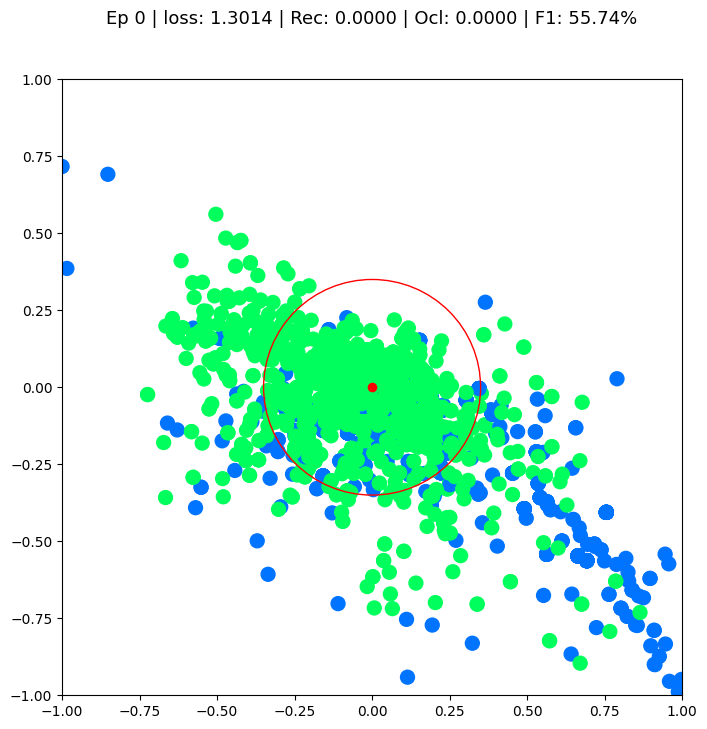

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot()

anim = animation.FuncAnimation(fig, animate, np.arange(0, epoch-300, 10), interval=800, repeat=True)
html = HTML(anim.to_html5_video())

display(html)

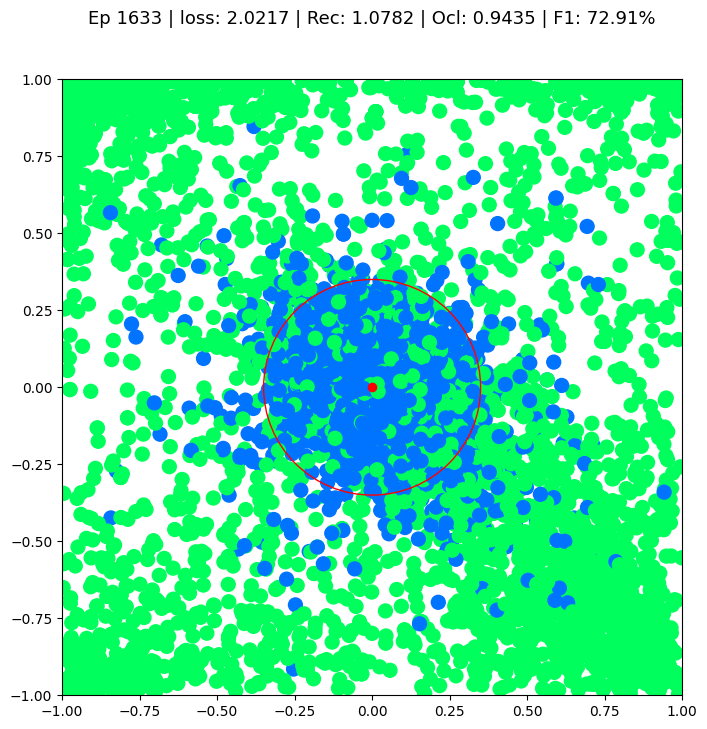

In [ ]:
i = 1633
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot()
embed = embeddings[i].detach().cpu().numpy()
center = centers[i].detach().cpu().numpy()
r = radiuss[i].detach().cpu().numpy()
ax.clear()
ax.scatter(embed[:, 0], embed[:, 1], s=100, c=G.label, cmap="hsv", vmin=-2, vmax=3)
ax.scatter(center[0], center[1], s=35, c='red', cmap="hsv", vmin=-2, vmax=3)
circle = plt.Circle((center[0], center[1]), r, color='red', fill=False)
plt.gca().add_artist(circle)
plt.title(f'Ep {i} | loss: {losses[i]:.4f} | Rec: 'f'{losses_rec[i]:.4f} |'
          ' Ocl: 'f'{losses_ocl[i]:.4f} | F1: {accuracies[i]*100:.2f}%', fontsize=13, pad=40)

plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.show()